Current char:  -
Next char:  2
True
Current factor char:  -
Current factor char:  (
Current char:  x
Next char:  +
False
Current factor char:  x
Char is not a digit
Current factor char:  z
Char is not a digit
Current factor char:  2
Current factor char:  (
Current char:  z
Next char:  -
False
Current factor char:  z
Char is not a digit
Current factor char:  x
Char is not a digit
Current factor char:  y
Char is not a digit
Current factor char:  (
Current char:  z
Next char:  *
False
Current factor char:  z
Char is not a digit
Current factor char:  x
Char is not a digit
Current factor char:  y
Char is not a digit
Original expression: -2.1*(x +z)^2 + (z - x*y) + (z*x - y) 
Parsed expression: <__main__.PolynomialParser object at 0x000002593F8EF4A0>
-2.1 * (x + z)^2.0 + z - x * y + z * x - y
<class '__main__.Addition'>
[<__main__.Addition object at 0x0000025940E31B20>, <__main__.Subtraction object at 0x000002593D5F5F10>]
-2.1 * (x + z)^2.0 + z - x * y
<class '__main__.Addition'>
[<__main__.

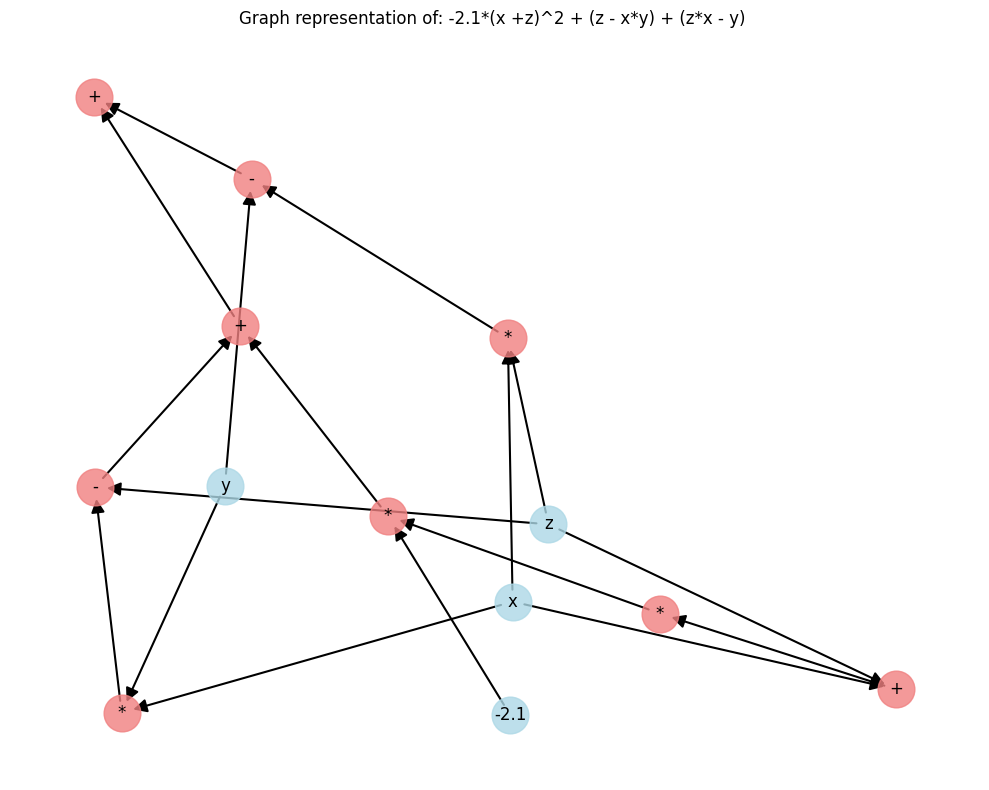

In [20]:
class PolynomialTerm:
    def __hash__(self):
        return hash(str(self))
    
    def __str__(self):
        return str(self.value)
    
    def is_number(self):
        return False
        
    def is_symbol(self):
        return False


class Variable(PolynomialTerm):
    def __init__(self, value):
        self.value = value
        
    def is_symbol(self):
        return True


class Constant(PolynomialTerm):
    def __init__(self, value):
        self.value = float(value)
        
    def is_number(self):
        return True
        
    @property
    def is_integer(self):
        return self.value == int(self.value)
         
    def __gt__(self, second):
        if isinstance(second, Constant):
            return self.value > second.value
        return self.value > second
        
    def __eq__(self, second):
        if isinstance(second, Constant):
            return self.value == second.value
        return self.value == second
    
    def __hash__(self):
        return hash(self.value)



class BinaryOperation(PolynomialTerm):
    def __init__(self, left, right):
        self.left = left
        self.right = right
    
    @property
    def args(self):
        return [self.left, self.right]


class Addition(BinaryOperation):
    def __str__(self):
        return f"{self.left} + {self.right}"
    

class Subtraction(BinaryOperation):
    def __str__(self):
        return f"{self.left} - {self.right}"
    


class Multiplication(BinaryOperation):
    def __str__(self):
        # Add parentheses around additions and subtractions to preserve precedence
        left_str = str(self.left)
        right_str = str(self.right)

        if isinstance(self.left, (Addition, Subtraction)):
            left_str = f"({left_str})"
            
        if isinstance(self.right, (Addition, Subtraction)):
            right_str = f"({right_str})"
            
        return f"{left_str} * {right_str}"
    

class Power(BinaryOperation):
    def __str__(self):
        # Add parentheses around the base if needed
        left_str = str(self.left)
        if isinstance(self.left, (Addition, Subtraction, Multiplication)):
            left_str = f"({left_str})"
            
        return f"{left_str}^{self.right}"
    

class UnaryMinus(PolynomialTerm):
    def __init__(self, value):
        self.value = value
    
    def __str__(self):
        term_str = str(self.value)
        if isinstance(self.value, (Addition, Subtraction, Multiplication)):
            term_str = f"({term_str})"
        return f"-{term_str}"
    
    def is_number(self):
        return self.value.is_number() if hasattr(self.value, 'is_number') else False
    
    def could_extract_minus_sign(self):
        return True
    
    @property
    def args(self):
        return [self.value]



class PolynomialParser:
    
    def __init__(self, expr_string):
        self.expr_tree = None
        self.parse(expr_string)

    
    def parse(self, expr):
        self.expr = expr.replace(' ', '') 
        self.pos = 0
        self.expr_tree = self._parse_expression()
        return self
    
    def _current_char(self):
        if self.pos >= len(self.expr):
            return None
        return self.expr[self.pos]
    
    def _next_char(self):
        if self.pos >= len(self.expr):
            return None
        return self.expr[self.pos + 1]
    
    def _parse_expression(self):
        print("Current char: ", self._current_char())
        print("Next char: ", self.expr[self.pos + 1])
        print(self._next_char().isdigit())
        if self._current_char() == '-' and not self._next_char().isdigit():
            self.pos += 1
            left = Multiplication(Constant(-1.0), self._parse_term())
        else:
            left = self._parse_term()
        
        while self._current_char() in ('+', '-'):
            op = self._current_char()
            self.pos += 1
            right = self._parse_term()
            
            if op == '+':
                left = Addition(left, right)
            else:
                left = Subtraction(left, right)
        
        return left
    
    def _parse_term(self):
        left = self._parse_factor()
        
        while self._current_char() == '*':
            self.pos += 1
            right = self._parse_factor()
            left = Multiplication(left, right)
                
        return left
    
    def _parse_factor(self):
        char = self._current_char()
        next_char = self._next_char()
        print("Current factor char: ", char)

        
        # Handle unary minus
        if char == '-' and not self.expr[self.pos + 1].isdigit():
            self.pos += 1
            return UnaryMinus(self._parse_factor())
        
        # Brackets
        if char == '(':
            self.pos += 1
            expr = self._parse_expression()
            self.pos += 1  # Skip closing bracket
            
            if self._current_char() == '^':
                self.pos += 1
                exponent = self._parse_factor()
                return Power(expr, exponent)
                
            return expr
        
        # Handle numbers
        if char.isdigit() or (char == '-' and self._next_char().isdigit()):
            return self._parse_number()
        print("Char is not a digit")
        
        # Handle variables
        if char.isalpha():
            var = self._parse_variable()
            
            # Check for power after variable
            # print(self._current_char())
            if self._current_char() == '^':
                self.pos += 1
                exponent = self._parse_factor()
                return Power(var, exponent)

           
            return var
            

    
    def _parse_number(self):
        start_pos = self.pos

        while self._current_char().isdigit() or self._current_char() == '.' or self._current_char() == '-':
            self.pos += 1
        
        # # Parse integer part
        # while self._current_char() and self._current_char().isdigit():
        #     self.pos += 1
        
        # # Parse decimal part if present
        # if self._current_char() == '.':
        #     print("Decimal: ", self._current_char())
        #     self.pos += 1
            
        #     if not self._current_char() or not self._current_char().isdigit():
        #         raise ValueError(f"Expected digit after decimal point at position {self.pos}")
                
        #     while self._current_char() and self._current_char().isdigit():
        #         self._advance()
        
        # Create constant
        value = float(self.expr[start_pos:self.pos])
        return Constant(value)
    
    def _parse_variable(self):
        start_pos = self.pos
        
        while self._current_char().isalnum():
            self.pos += 1
            
        variable = self.expr[start_pos:self.pos]
        return Variable(variable)


# Modified process_expression function to work with our custom polynomial structures
def process_expression(expr, graph, node_id, parent_id=None, top_level=False, expr_to_id=None):

    print(expr)
    
    if expr_to_id is None:
        expr_to_id = {}
    
    print(type(expr))

    # Checks if the exact expression has been processed and does not add it if so
    # Uses hash to create a unique key for each expression element
    expr_hash = hash(expr)
    if expr_hash in expr_to_id:
        node_for_expr = expr_to_id[expr_hash]
        if parent_id is not None:
            graph.add_edge(node_for_expr, parent_id)

        return node_id, node_for_expr
    
    # Handle Addition and Multiplication operations
    if isinstance(expr, (Addition, Multiplication)):
        args = list(expr.args)
        print(args)
        
        if top_level:
            # if top_level = True the first time this function executes, there is a non binary addition as the last addition in the sequence of polynomials
            add_node = node_id
            graph.add_node(add_node, label="+" if isinstance(expr, Addition) else "*", type="operation")
            expr_to_id[expr_hash] = add_node
            node_id += 1
            
            # Process each term in the top-level expression
            for term in args:
                node_id, child_id = process_expression(term, graph, node_id, add_node, top_level=False, expr_to_id=expr_to_id)
            
            if parent_id is not None:
                graph.add_edge(add_node, parent_id)
            return node_id, add_node
        else:
            # Creates a binary tree for addition/multiplication
            if isinstance(expr, Addition,):
                label = "+"
            else:
                label = "*"
                
            if len(args) > 0:
                left_expr = args[0]
                node_id, left_id = process_expression(left_expr, graph, node_id, top_level=False, expr_to_id=expr_to_id)
        
                for i in range(1, len(args)):
                    expr_branch = args[i]
                    
                    if isinstance(expr, Addition) and hasattr(expr_branch, 'could_extract_minus_sign') and expr_branch.could_extract_minus_sign():
                        # For addition with negative term, create a subtraction node instead
                        parent_node = node_id
                        graph.add_node(parent_node, label="-", type="operation")
                        expr_to_id[expr_hash] = parent_node
                        node_id += 1
                        
                        # Connect to the parent node if exists
                        if parent_id is not None:
                            graph.add_edge(parent_node, parent_id)
                            parent_id = parent_node
                        
                        # Left branch is the result so far
                        graph.add_edge(left_id, parent_node, label='left')
                        
                        # Right branch is the term without the negative sign
                        # Use the term directly if it's UnaryMinus, otherwise create negation
                        if isinstance(expr_branch, UnaryMinus):
                            term_without_minus = expr_branch.term
                        else:
                            term_without_minus = expr_branch  # This shouldn't happen with our implementation
                            
                        node_id, right_id = process_expression(term_without_minus, graph, node_id, top_level=False, expr_to_id=expr_to_id)
                        graph.add_edge(right_id, parent_node, label='right')
                    else:
                        # Standard addition or multiplication node
                        parent_node = node_id
                        graph.add_node(parent_node, label=label, type="operation")
                        expr_to_id[expr_hash] = parent_node
                        node_id += 1
                        
                        # Connect to the parent node if exists
                        if parent_id is not None:
                            graph.add_edge(parent_node, parent_id)
                            parent_id = parent_node
                        
                        # Left branch is the result so far
                        graph.add_edge(left_id, parent_node, label='left')
                        
                        # Right branch is the current term
                        node_id, right_id = process_expression(expr_branch, graph, node_id, top_level=False, expr_to_id=expr_to_id)
                        graph.add_edge(right_id, parent_node, label='right')
                    
                    left_id = parent_node  # for chaining operations
                
                return node_id, left_id
            else:
                # Handle empty args case (unlikely but for robustness)
                return node_id, None
                
    # Handle Power operation
    elif isinstance(expr, Power):
        base, exp = expr.args
        print(exp, type((exp)))
        if hasattr(exp, 'is_integer') and exp.is_integer and exp > 1:
            return _handle_power_as_multiplication(expr, base, exp, graph, node_id, parent_id, expr_to_id)

            
    # Handle variables
    elif isinstance(expr, Variable) or hasattr(expr, 'is_symbol') and expr.is_symbol():
        curr_id = node_id
        graph.add_node(curr_id, label=str(expr), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id
    
    # Handle constants
    elif hasattr(expr, 'is_number') and expr.is_number():
        curr_id = node_id
        print(expr)
        # Display negative numbers directly with the negative sign
        graph.add_node(curr_id, label=str(expr), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id
    
    # Handle unary minus
    elif isinstance(expr, UnaryMinus):
        curr_id = node_id
        graph.add_node(curr_id, label="-", type="operation")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        
        # Process the term inside the unary minus
        node_id, term_id = process_expression(expr.value, graph, node_id, curr_id, top_level=False, expr_to_id=expr_to_id)
        
        return node_id, curr_id
    
    # Handle subtraction
    elif isinstance(expr, Subtraction):
        sub_node = node_id
        graph.add_node(sub_node, label="-", type="operation")
        expr_to_id[expr_hash] = sub_node
        node_id += 1
        
        if parent_id is not None:
            graph.add_edge(sub_node, parent_id)
        
        # Process left and right terms
        node_id, left_id = process_expression(expr.left, graph, node_id, sub_node, top_level=False, expr_to_id=expr_to_id)
        graph.add_edge(left_id, sub_node, label='left')
        
        node_id, right_id = process_expression(expr.right, graph, node_id, sub_node, top_level=False, expr_to_id=expr_to_id)
        graph.add_edge(right_id, sub_node, label='right')
        
        return node_id, sub_node
    
    else:
        # Default case for any other expression types
        curr_id = node_id
        graph.add_node(curr_id, label=str(expr), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id


# Function to help with processing power operations
def _handle_power_as_multiplication(expr, base, exp, graph, node_id, parent_id, expr_to_id):
    expr_hash = hash(expr)
    
    # Handle the base case of x^1 (just return the base itself)
    if exp == 1:
        return process_expression(base, graph, node_id, parent_id, top_level=False, expr_to_id=expr_to_id)
    
    # Special case for x^2: Create a multiplication node with two edges from the same x node
    if exp == 2:
        # First, process the base to get its node
        node_id, base_id = process_expression(base, graph, node_id, top_level=False, expr_to_id=expr_to_id)
        
        # Create multiplication node
        mul_node = node_id
        graph.add_node(mul_node, label="*", type="operation")
        expr_to_id[expr_hash] = mul_node
        node_id += 1
        
        # Add two edges from the same base node to the multiplication node
        graph.add_edge(base_id, mul_node, label='left')
        graph.add_edge(base_id, mul_node, label='right')
        
        # Connect to parent if needed
        if parent_id is not None:
            graph.add_edge(mul_node, parent_id)
            
        return node_id, mul_node
    
    # For exponents > 2, create a binary tree of multiplications
    # For odd exponents: x^n = x * (x^(n-1))
    # For even exponents: x^n = (x^(n/2)) * (x^(n/2))
    if exp % 2 == 0:
        # For even exponents, create a balanced tree
        left_exp = exp // 2
        right_exp = exp // 2
    else:
        # For odd exponents, we'll do x * (x^(n-1))
        left_exp = 1
        right_exp = exp - 1
    
    # Process left part
    if left_exp == 1:
        node_id, left_id = process_expression(base, graph, node_id, top_level=False, expr_to_id=expr_to_id)
    else:
        left_power_expr = base ** left_exp
        node_id, left_id = _handle_power_as_multiplication(left_power_expr, base, left_exp, graph, node_id, None, expr_to_id)
    
    # Process right part
    if right_exp == 1:
        node_id, right_id = process_expression(base, graph, node_id, top_level=False, expr_to_id=expr_to_id)
    else:
        right_power_expr = base ** right_exp
        node_id, right_id = _handle_power_as_multiplication(right_power_expr, base, right_exp, graph, node_id, None, expr_to_id)
    
    # Create multiplication node
    mul_node = node_id
    graph.add_node(mul_node, label="*", type="operation")
    expr_to_id[expr_hash] = mul_node
    node_id += 1
    
    # Connect the operands
    graph.add_edge(left_id, mul_node, label='left')
    graph.add_edge(right_id, mul_node, label='right')
    
    # Connect to parent if needed
    if parent_id is not None:
        graph.add_edge(mul_node, parent_id)
        
    return node_id, mul_node



# Example usage demonstrating how to connect the OrderPreservingPolynomial with process_expression
import networkx as nx
import matplotlib.pyplot as plt

# Parse a polynomial expression
expr_str = "-1.2*x^2 + 3.45*(z - (3.4*x*y + y*z) )"
expr_str = "-2.1*(x +z)^2 + (z - x*y) + (z*x - y) "
poly = PolynomialParser(expr_str)
print(f"Original expression: {expr_str}")
print(f"Parsed expression: {poly}")

# Create a graph representation
G = nx.DiGraph()
node_id = 0
node_id, root_id = process_expression(poly.expr_tree, G, node_id, top_level=True)


pos = nx.spring_layout(G) 

plt.figure(figsize=(10, 8))

# Draw operation nodes as red circles
operation_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'operation']
nx.draw_networkx_nodes(G, pos, nodelist=operation_nodes, node_color='lightcoral', 
                        node_size=700, alpha=0.8)

# Draw value nodes as blue circles
value_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'value']
nx.draw_networkx_nodes(G, pos, nodelist=value_nodes, node_color='lightblue', 
                        node_size=700, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20, width=1.5)

# Add labels
labels = {n: d['label'] for n, d in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_family='sans-serif')

plt.title(f"Graph representation of: {expr_str}")
plt.axis('off')
plt.tight_layout()
plt.show()
